# Visualization
Here the results of the top performing models are compared.

For regression:
- baseline rfr
- baseline graph
- multitask graph
- transfer graph

For classification:
- baseline rfc
- multitask graph

Most of the processing here is repetition from notebooks in the doc/multitask* and transfer notebooks.
***
***


In [1]:
import deepchem as dc
import numpy as np
import pandas as pd
import optuna
from functools import reduce

import cytoxnet.dataprep.io as io
import cytoxnet.dataprep.dataprep as dataprep
import cytoxnet.dataprep.featurize as feat
from cytoxnet.models.models import ToxModel

## Prepare the datasets to use, just as before

In [2]:
## !!!!!!temporary until database query works
fish = io.load_data('../database/fish.csv', cols=['smiles', 'fish_LC50'])
daphnia = io.load_data('../database/daphnia.csv', cols=['smiles', 'daphnia_EC50'])
algea = io.load_data('../database/algea.csv', cols=['smiles', 'algea_EC50'])
rat  = io.load_data('../database/rat.csv', cols=['smiles', 'rat_LD50'])
ecoli  = io.load_data('../database/ecoli.csv', cols=['smiles', 'ecoli_MIC'])

raw = reduce(
    lambda x, y: pd.merge(x, y, how='outer', on = 'smiles'),
    [fish, daphnia, algea, rat, ecoli]
)
multitask_names = [
    'fish_LC50',
    'daphnia_EC50',
    'algea_EC50',
    'rat_LD50',
    'ecoli_MIC'
]

In [3]:
data_f = feat.add_features(raw, method='RDKitDescriptors', codex='../database/compounds.csv')
data_f = feat.add_features(data_f, method='ConvMolFeaturizer')

Get test indexes

In [4]:
algea_only = data_f[~data_f.isna()['algea_EC50']]
algea_index = algea_only.index
test_index = algea_only.sample(frac=.2, random_state=0).index
baseline_index = algea_only.drop(index=test_index).index

### Regression data

#### Baseline RFR and graph

In [5]:
# create the dataset
baseline_rfr = dataprep.convert_to_dataset(
    data_f,
    X_col='RDKitDescriptors',
    y_col=[
        'algea_EC50'
    ]
).select(np.isin(data_f.index, algea_index))

baseline_graph = dataprep.convert_to_dataset(
    data_f,
    X_col='ConvMolFeaturizer',
    y_col=[
        'algea_EC50'
    ]
).select(np.isin(data_f.index, algea_index))

#### Multitask graph

In [6]:
sp_graph_r = dataprep.convert_to_dataset(
    data_f,
    X_col='ConvMolFeaturizer',
    y_col=multitask_names,
)

In [7]:
sp_graph_r = dataprep.handle_sparsity(sp_graph_r)

### Rat set (for transfer)

In [8]:
rat_r = feat.add_features(rat, method='ConvMolFeaturizer')

In [9]:
trans_graph_r = dataprep.convert_to_dataset(
    rat_r,
    X_col='ConvMolFeaturizer',
    y_col=['rat_LD50']
)

### Classification data

First binarize

In [10]:
binarized = dataprep.binarize_targets(data_f, target_cols=multitask_names, percentile = .9)

#### Baseline rfr and graph

In [11]:
# create the dataset
baseline_rfc = dataprep.convert_to_dataset(
    binarized,
    X_col='RDKitDescriptors',
    y_col=[
        'algea_EC50'
    ]
).select(np.isin(data_f.index, algea_index))

#### Multitask graph

In [12]:
sp_graph_c = dataprep.convert_to_dataset(
    binarized,
    X_col='ConvMolFeaturizer',
    y_col=multitask_names,
    w_label='w'
)

## Conduct regression predictions

### baseline g

In [240]:
baseline_rfr_study = optuna.load_study(
    study_name='opt',
    storage="sqlite:///../multitask_learning/regression/baseline_r.db"
)

In [241]:
baseline_rfr_params = baseline_rfr_study.best_params

In [242]:
# normalize it
baseline_rfr_normed, baseline_rfr_transformations = dataprep.data_transformation(
    baseline_rfr, transformations = ['NormalizationTransformer'],
    to_transform = ['y']
)
# split out dev and test
baseline_rfr_test = baseline_rfr_normed.select(np.isin(baseline_rfr_normed.ids, test_index))
baseline_rfr_dev = baseline_rfr_normed.select(np.isin(baseline_rfr_normed.ids, baseline_index))

Get the original unnormed test vector for plotting

In [243]:
true = data_f.loc[baseline_rfr_test.ids, 'algea_EC50']

In [244]:
baseline_rfr_model = ToxModel('RFR', **baseline_rfr_params, transformers=baseline_rfr_transformations)

In [245]:
baseline_rfr_model.fit(baseline_rfr_dev)

In [246]:
baseline_rfr_preds = baseline_rfr_model.predict(baseline_rfr_test, untransform=True)

### baseline graph

In [247]:
baseline_g_study = optuna.load_study(
    study_name='opt',
    storage="sqlite:///../transfer_testing/graph_r.db"
)

In [248]:
baseline_g_params = baseline_g_study.best_params

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution 

In [249]:
# normalize it
baseline_g_normed, baseline_g_transformations = dataprep.data_transformation(
    baseline_graph, transformations = ['NormalizationTransformer'],
    to_transform = ['y']
)
# split out dev and test
baseline_g_test = baseline_g_normed.select(np.isin(baseline_g_normed.ids, test_index))
baseline_g_dev = baseline_g_normed.select(np.isin(baseline_g_normed.ids, baseline_index))

In [250]:
baseline_g_model = ToxModel(
    'GraphCNN',
    **baseline_g_params,
    transformers=baseline_g_transformations,
    mode='regression'
)

In [251]:
baseline_g_model.fit(baseline_g_dev, nb_epoch=100)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_14:0", shape=(159,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_13:0", shape=(159, 128), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_17:0", shape=(586,), dtype=int32), values=Tensor("gradient_

0.042908916473388674

In [252]:
baseline_g_preds = baseline_g_model.predict(baseline_g_test, untransform=True)

### multitask graph

In [253]:
sparse_g_r_study = optuna.load_study(
    study_name='opt',
    storage="sqlite:///../multitask_learning/regression/graph_r.db"
)

In [254]:
sparse_g_r_params = sparse_g_r_study.best_params

In [255]:
# normalize it
sparse_g_r_normed, sparse_g_r_transformations = dataprep.data_transformation(
    sp_graph_r, transformations = ['NormalizationTransformer'],
    to_transform = ['y']
)
# split out dev and test
sparse_g_r_test = sparse_g_r_normed.select(np.isin(sparse_g_r_normed.ids, test_index))
sparse_g_r_dev = sparse_g_r_normed.select(np.isin(sparse_g_r_normed.ids, baseline_index))

In [256]:
sparse_g_model = ToxModel(
    'GraphCNN',
    **sparse_g_r_params,
    transformers=sparse_g_r_transformations,
    mode='regression',
    tasks = multitask_names
)

In [257]:
sparse_g_model.fit(sparse_g_r_dev, nb_epoch=50)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_11/Reshape_14:0", shape=(927,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_11/Reshape_13:0", shape=(927, 128), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_11/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_11/Reshape_17:0", shape=(3610,), dtype=int32), values=Tensor("gradient

0.42761138916015623

In [258]:
sparse_g_preds = sparse_g_model.predict(sparse_g_r_test, untransform=True)[:,2]

### transfer learn

In [68]:
trans_graph_r_normed, trans_graph_r_transformations = dataprep.data_transformation(
    trans_graph_r, transformations = ['NormalizationTransformer'],
    to_transform = ['y']
)

In [69]:
transfer = ToxModel(
    'GraphCNN',
    mode='regression',
    transformers = trans_graph_r_transformations,
    **baseline_g_params
)

In [70]:
transfer.fit(trans_graph_r_normed, nb_epoch=200)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_14:0", shape=(197,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_13:0", shape=(197, 128), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_17:0", shape=(814,), dtype=int32), values=Tensor("gradient_tape

0.027444281578063966

In [71]:
transfer.transformers = baseline_g_transformations

In [72]:
for layer in transfer._model.model.layers[:-1]:
    layer.trainable = False

In [74]:
transfer.fit(baseline_g_dev, nb_epoch=100)

0.01749937891960144

In [238]:
transfer_preds = transfer.predict(baseline_g_test, untransform=True)

### Visualize

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
sns.set_style('whitegrid')

In [260]:
dfs = []
preds = {
    'Baseline RFR': baseline_rfr_preds.reshape(-1),
    'Baseline GNN': baseline_g_preds.reshape(-1),
    'Multitask GNN': sparse_g_preds.reshape(-1),
    'Transfer GNN': transfer_preds.reshape(-1)
}
for name, preds_ in preds.items():
    df = pd.DataFrame({'True': true.values, 'Predicted': preds_, 'Model': name})
    dfs.append(df)
df = pd.concat(dfs)

In [261]:
minv = df[['True', 'Predicted']].min().min()
maxv = df[['True', 'Predicted']].max().max()

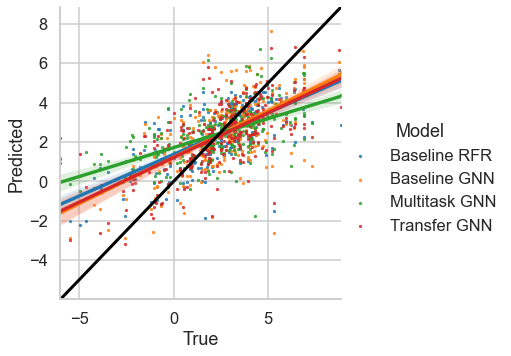

In [262]:
g = sns.lmplot(data = df, x='True', y='Predicted', hue='Model', scatter_kws={'s':5})
g.axes[0][0].plot([minv, maxv], [minv, maxv], c='k', linewidth=3)
g.axes[0][0].set_xlim([minv, maxv])
g.axes[0][0].set_ylim([minv, maxv])
fig = plt.gcf()

In [263]:
fig.savefig('all_model_regression.png', dpi=300)

## Classification models

### baseline

In [308]:
baseline_rfc_study = optuna.load_study(
    study_name='opt',
    storage="sqlite:///../multitask_learning/classification/baseline_c.db"
)

In [309]:
baseline_rfc_params = baseline_rfc_study.best_params

In [310]:
# split out dev and test
baseline_rfc_test = baseline_rfc.select(np.isin(baseline_rfc.ids, test_index))
baseline_rfc_dev = baseline_rfc.select(np.isin(baseline_rfc.ids, baseline_index))

Get the original unnormed test vector for plotting

In [311]:
true = binarized.loc[baseline_rfc_test.ids, 'algea_EC50']

In [312]:
baseline_rfc_model = ToxModel('RFC', **baseline_rfc_params)

In [313]:
baseline_rfc_model.fit(baseline_rfc_dev)

In [314]:
baseline_rfc_preds = np.argmax(baseline_rfc_model.predict(baseline_rfc_test), axis=1)

### graph multitask

In [315]:
sparse_g_c_study = optuna.load_study(
    study_name='opt',
    storage="sqlite:///../multitask_learning/classification/graph_c.db"
)

In [316]:
sparse_g_c_params = sparse_g_c_study.best_params

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128] which is of type list.
  warnings.warn(message)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/optuna/distributions.py:430: UserWarning: Choices for a categorical distribution 

In [317]:
# split out dev and test
sparse_g_c_test = sp_graph_c.select(np.isin(sp_graph_c.ids, test_index))
sparse_g_c_dev = sp_graph_c.select(np.isin(sp_graph_c.ids, baseline_index))

In [318]:
sparse_g_model = ToxModel(
    'GraphCNN',
    **sparse_g_c_params,
    mode='classification',
    tasks = multitask_names
)

In [319]:
sparse_g_model.fit(sparse_g_c_dev, nb_epoch=50)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_16/Reshape_14:0", shape=(967,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_16/Reshape_13:0", shape=(967, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_16/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_16/Reshape_17:0", shape=(3470,), dtype=int32), values=Tensor("gradi

0.03509611368179321

In [320]:
sparse_g_preds = np.argmax(sparse_g_model.predict(sparse_g_c_test), axis=2)[:,2]

### visualize

In [334]:
import sklearn.metrics

In [335]:
dfs = []
preds = {
    'Baseline RFC': baseline_rfc_preds.reshape(-1),
    'Multitask GNN': sparse_g_preds.reshape(-1)
}
for name, preds_ in preds.items():
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(
        true.values, preds_
    )
    df = pd.DataFrame({'False positive rate': fpr, 'True positive rate':tpr, 'thresholds':thresholds, 'Model':name})
    
    dfs.append(df)
df = pd.concat(dfs)

In [336]:
df

,False positive rate,True positive rate,thresholds,Model
0,0.000000,0.000000,2,Baseline RFC
1,0.866667,0.988417,1,Baseline RFC
2,1.000000,1.000000,0,Baseline RFC
0,0.000000,0.000000,2,Multitask GNN
1,0.866667,0.984556,1,Multitask GNN
2,1.000000,1.000000,0,Multitask GNN


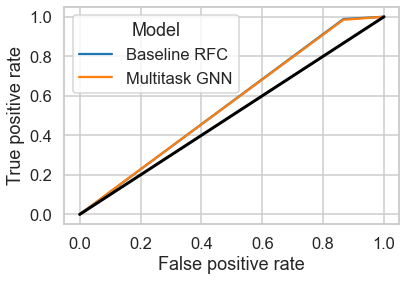

In [337]:
g = sns.lineplot(data=df, x='False positive rate', y='True positive rate', hue='Model')
g.axes.plot([0, 1], [0, 1], c='k', linewidth=3)
fig = plt.gcf()

In [338]:
fig.savefig('all_model_classification.png', dpi=300, bbox_inches='tight')

## Data visualization final pres

Create a plot to show the binarization of unlogged targets - very biased

In [326]:
data = io.load_data('chembl_ecoli_MIC')

In [327]:
data['ecoli_MIC'] = data['ecoli_MIC'].apply(lambda x: np.exp(x))

In [328]:
ninty_percentile = data.quantile(.9)['ecoli_MIC']

In [329]:
ninty_percentile

132.00000000000009

In [330]:
data = data['ecoli_MIC'].values

Text(0.5, 0.98, 'KDE of E. coli MIC')

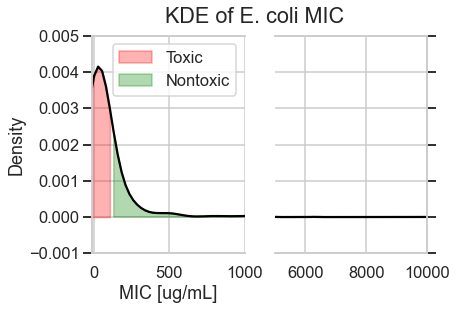

In [331]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
sns.kdeplot(x=data, ax=ax1, color='k', gridsize=500)
sns.kdeplot(x=data, ax=ax2, color='k', gridsize=500)
ax1.set_xlim([-10, 1e3])
ax2.set_xlim([.5e4, 1e4])
ax2.set_ylim([-.001, .005])
ax1.set_xlabel('MIC [ug/mL]')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.yaxis.tick_right()

leftxy = ax1.lines[0].get_xydata()
toxdata = leftxy[leftxy[:,0]<=ninty_percentile]
nontoxdata = leftxy[leftxy[:,0]>=ninty_percentile]
ax1.fill_between(toxdata[:,0],toxdata[:,1], color="red", alpha=0.3, label='Toxic')
ax1.fill_between(nontoxdata[:,0],nontoxdata[:,1], color="green", alpha=0.3, label='Nontoxic')
ax1.legend()
fig.suptitle('KDE of E. coli MIC')

In [333]:
fig.savefig('kde_binarized.png', dpi=300, bbox_inches='tight')